In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

parent_dir = os.path.abspath("..")
sys.path.append(parent_dir)

from lib import data_utils

In [2]:
DATA_FREQUENCY = dt.timedelta(minutes=5)

In [3]:
def difference(x, d):
    for _ in range(d):
        x = x[1:] - x[:-1]
    
    return x

def seasonal_difference(x, s):
    return x[s:] - x[:-s]

def plot_correlations(x, nlags=256):
    plt.figure(figsize=(16, 3))
    plt.stem(acf(x, nlags=nlags))
    plt.show()
    plt.figure(figsize=(16, 3))
    plt.stem(pacf(x, nlags=nlags))
    plt.show()

In [4]:
train = np.load("../data/inputs/5083_P2_o3_h6_sensor_data/train_ts.npz")
val = np.load("../data/inputs/5083_P2_o3_h6_sb3_sensor_data/val.npz")
test = np.load("../data/inputs/5083_P2_o3_h6_sb3_sensor_data/test.npz")

In [5]:
x_train = train["data"]
ts_train = train["timestamps"]
x_val = val["x"]
y_val = val["y"]
x_ts_val = val["timestamps_x"]
y_ts_val = val["timestamps_y"]
x_test = test["x"]
y_test = test["y"]
x_ts_test = test["timestamps_x"]
y_ts_test = test["timestamps_y"]

In [6]:
detector = 0

x = x_train[:, detector, 1]
x_val = x_val[:, :, detector, 1]
y_val = y_val[:, :, detector, 1]
x_test = x_test[:, :, detector, 1]
y_test = y_test[:, :, detector, 1]

In [7]:
print(x_train.shape)
print(x.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(7560, 15, 2)
(7560,)
(930, 3)
(930, 6)
(1860, 3)
(1860, 6)


In [8]:
def convert_to_fourier(x, c=2):
    days = pd.Series(x).dt.dayofweek / 7
    terms = []
    
    for i in range(2, c + 2, 2):
        angles = i * np.pi * days
        terms.append(np.sin(angles))
        terms.append(np.cos(angles))
    
    fourier_terms = np.column_stack(terms)
    
    return fourier_terms

In [9]:
exog_train = convert_to_fourier(ts_train)
print(exog_train.shape)

(7560, 2)


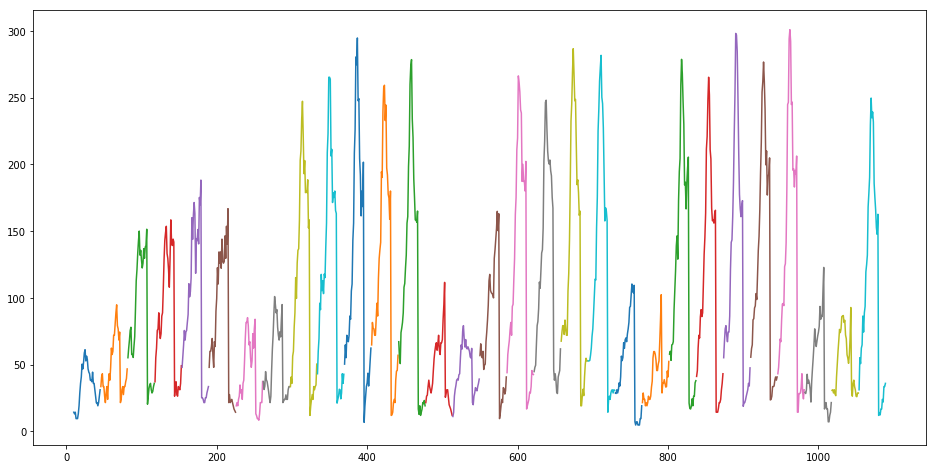

In [10]:
plt.figure(figsize=(16, 8))
j = 36
c=10
for i in range(30):
    plt.plot(np.arange(j*i+c, j*(i+1)+c), x[j*i+c:j*(i+1)+c])
plt.show()

In [11]:
x_0_0 = x
x_1_0 = difference(x, 1)
x_0_1 = seasonal_difference(x, 102)
x_1_1 = difference(seasonal_difference(x, 102), 1)

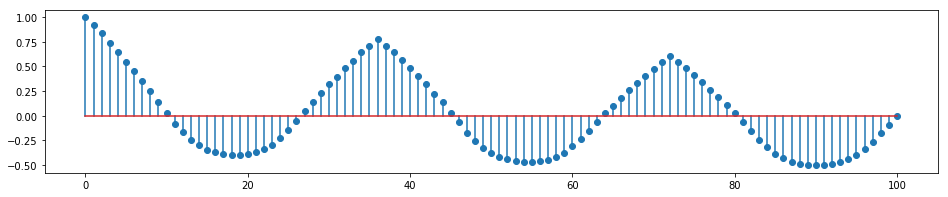

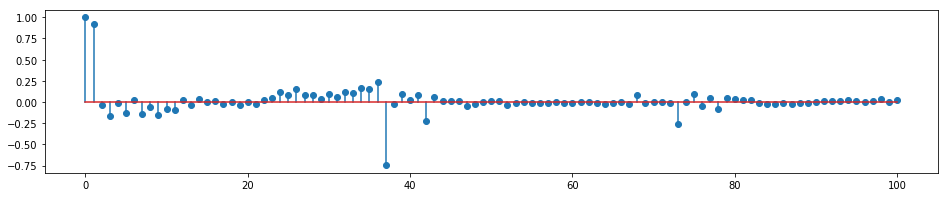

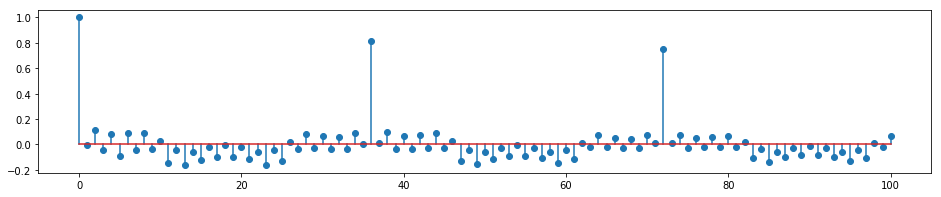

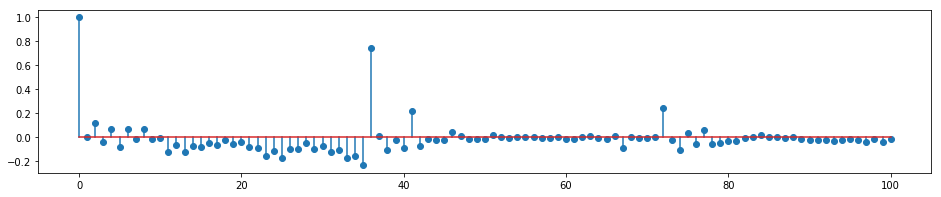

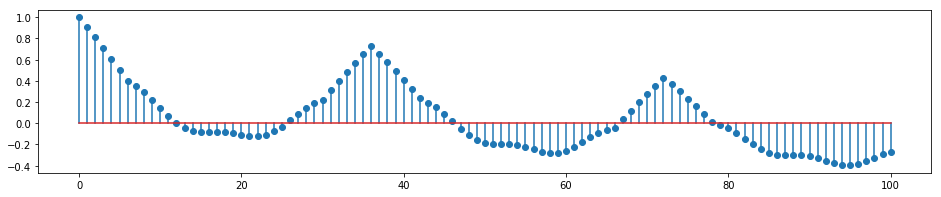

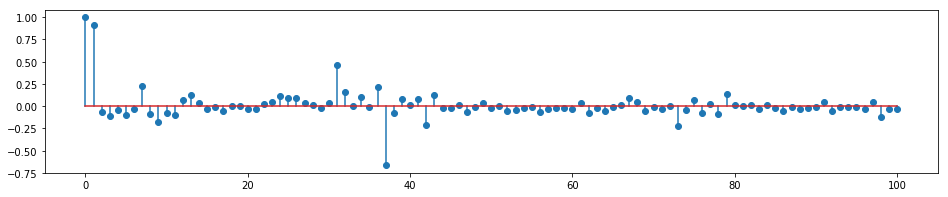

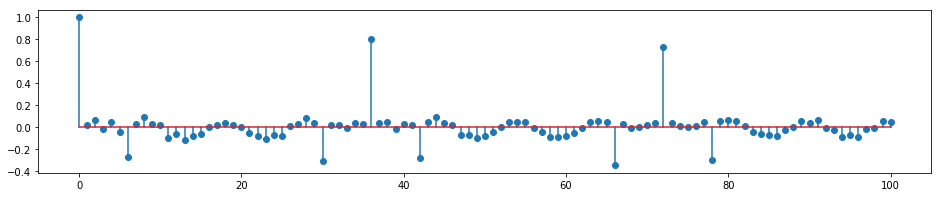

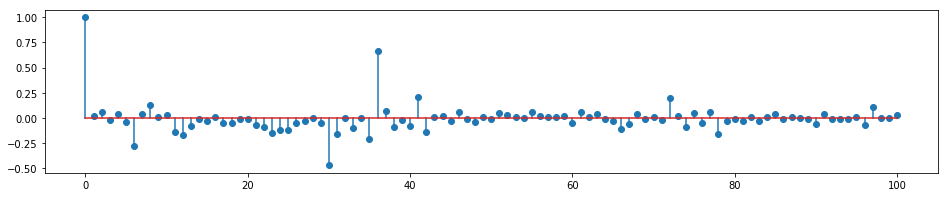

In [12]:
nlags = 100
plot_correlations(x_0_0, nlags=nlags)
plot_correlations(x_1_0, nlags=nlags)
plot_correlations(x_0_1, nlags=nlags)
plot_correlations(x_1_1, nlags=nlags)

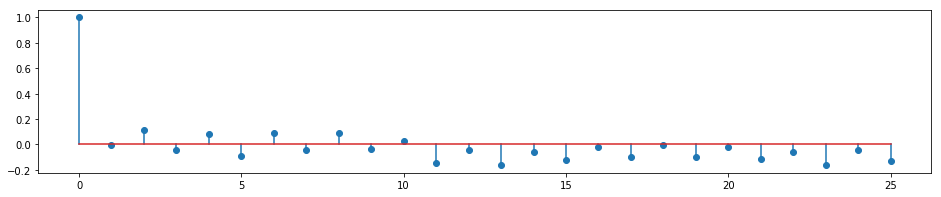

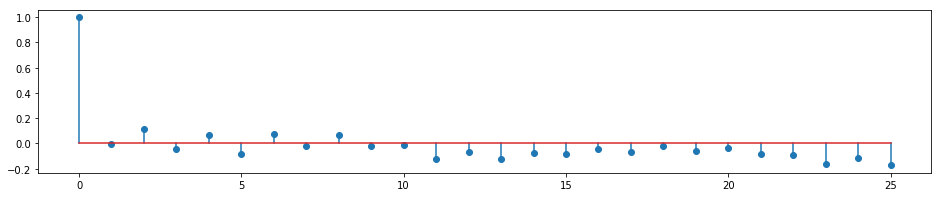

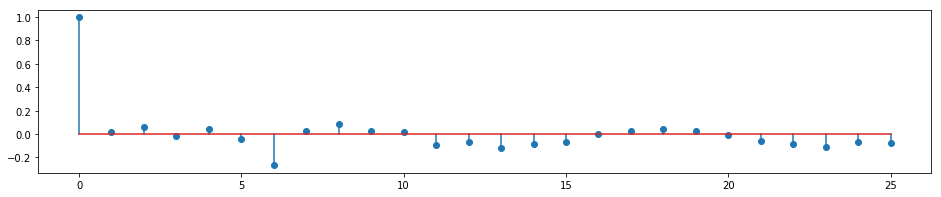

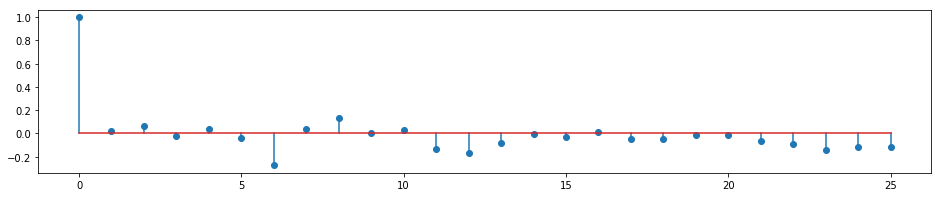

In [13]:
nlags = 25
#plot_correlations(x_0_0, nlags=nlags)
plot_correlations(x_1_0, nlags=nlags)
#plot_correlations(x_0_1, nlags=nlags)
plot_correlations(x_1_1, nlags=nlags)

# SARIMAX

In [14]:
def predict_sarimax(x, y, x_ts_val, y_ts_val, params, order=(0, 0, 0), seasonal_order=(0, 0, 0, 0)):
    predictions = np.empty(y.shape)
    horizon = y.shape[1]

    for i in range(x.shape[0]):
        x_exog = convert_to_fourier(x_ts_val[i, :])
        y_exog = convert_to_fourier(y_ts_val[i, :])
        model = SARIMAX(x[i, :], exog=x_exog, order=order, seasonal_order=seasonal_order)
        results = model.smooth(params)
        predictions[i, :] = results.forecast(horizon, exog=y_exog)
    
    return predictions

def fit_sarimax(x, exog, order, seasonal_order, x_val, y_val, x_ts_val, y_ts_val):
    model = SARIMAX(x, exog=exog, order=order, seasonal_order=seasonal_order)
    results = model.fit()
    
    display(results.summary())
    
    print("SSR: {}".format(np.mean(np.power(results.resid, 2))))
    print("AIC: {}".format(results.aic))
    print("BIC: {}".format(results.bic))
    
    # SARIMAX prediction and evaluation
    predictions = predict_sarimax(x_val, y_val, x_ts_val, y_ts_val, results.params,
                                  order=order, seasonal_order=seasonal_order)
    
    for h in range(y_val.shape[1]):
        if h in [0, 2, 5]:
            print(data_utils.get_standard_errors(y_val[:, h], predictions[:, h]))
    
    return results, predictions

# Online ARMAX

In [15]:
def predict_online_armax(x, y, x_ts_val, y_ts_val, order=(0, 0, 0), seasonal_order=None):
    predictions = np.empty(y.shape)
    horizon = y.shape[1]

    for i in range(x.shape[0]):
        x_exog = convert_to_fourier(x_ts_val[i, :])
        y_exog = convert_to_fourier(y_ts_val[i, :])
        model = SARIMAX(x[i, :], exog=x_exog, order=order)
        results = model.fit()
        predictions[i, :] = results.forecast(horizon, exog=y_exog)
    
    return predictions

def fit_online_armax(x, order, seasonal_order, x_val, y_val, x_ts_val, y_ts_val):
    # Online ARMAX prediction and evaluation
    predictions = predict_online_armax(x_val, y_val, x_ts_val, y_ts_val, order=order)
    
    for h in range(y_val.shape[1]):
        if h in [0, 2, 5]:
            print(data_utils.get_standard_errors(y_val[:, h], predictions[:, h]))
    
    return results, predictions

# Model running

In [16]:
orders = [
    [(0, 1, 0), (0, 0, 0, 0)],
    [(1, 1, 0), (0, 0, 0, 0)],
    [(0, 1, 1), (0, 0, 0, 0)],
#     [(1, 1, 1), (0, 0, 0, 0)],
#     [(1, 1, 0), (1, 0, 0, 36)],
#     [(0, 1, 1), (1, 0, 0, 36)],
#     [(1, 1, 1), (1, 0, 0, 36)],
    [(0, 1, 0), (0, 1, 0, 36)],
    [(0, 1, 1), (0, 1, 0, 36)],
    [(1, 1, 1), (0, 1, 0, 36)],
    [(0, 1, 0), (0, 1, 1, 36)],
    [(0, 1, 1), (0, 1, 1, 36)],
    [(1, 1, 1), (0, 1, 1, 36)],
]

In [17]:
res = []
preds = []

for order, seasonal_order in orders:
    results, predictions = fit_sarimax(x, exog_train, order, seasonal_order, x_val, y_val, x_ts_val, y_ts_val)
    res.append(results)
    preds.append(predictions)

/Users/victorchan/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7560
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -36116.543
Date:                Sun, 01 Dec 2019   AIC                          72239.086
Time:                        17:27:10   BIC                          72259.878
Sample:                             0   HQIC                         72246.223
                               - 7560                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            42.2900      0.640     66.055      0.000      41.035      43.545
x2            24.6622      0.560     44.040      0.000      23.565      25.760
sigma2       827.1904      3.528    234.458      0.000     820.275     834.105
===================================================================================
Ljung-Box (Q):                     6830.28   Jarque-Bera (JB):            256566.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -4.30
Prob(H) (two-sided):                  0.27   Kurtosis:                        30.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 827.2794125447379
AIC: 72239.08613824473
BIC: 72259.87762080062
{'mse': 232.9765161290323, 'rmse': 15.26356826332009, 'mae': 10.363870967741937, 'mape': 0.12573886296325548}
{'mse': 1323.2578064516129, 'rmse': 36.37661070594143, 'mae': 25.215483870967745, 'mape': 0.2515025521170199}
{'mse': 3643.553032258065, 'rmse': 60.36185080212555, 'mae': 44.02580645161291, 'mape': 0.36878490927308755}


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7560
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -36116.521
Date:                Sun, 01 Dec 2019   AIC                          72241.041
Time:                        17:27:16   BIC                          72268.763
Sample:                             0   HQIC                         72250.557
                               - 7560                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            42.2900      0.643     65.820      0.000      41.031      43.549
x2            24.6622      0.562     43.880      0.000      23.561      25.764
ar.L1         -0.0024      0.018     -0.136      0.892      -0.037       0.033
sigma2       827.2890      4.452    185.832      0.000     818.564     836.014
===================================================================================
Ljung-Box (Q):                     6831.58   Jarque-Bera (JB):            256099.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -4.30
Prob(H) (two-sided):                  0.27   Kurtosis:                        30.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 827.2745183360073
AIC: 72241.04147945519
BIC: 72268.76345619636
{'mse': 233.37213273178742, 'rmse': 15.276522272159571, 'mae': 10.37459320935887, 'mape': 0.12584584035437818}
{'mse': 1324.411135225483, 'rmse': 36.39245986774572, 'mae': 25.228772737212015, 'mape': 0.2516214725519057}
{'mse': 3644.8194754423625, 'rmse': 60.37234031775116, 'mae': 44.03503726620391, 'mape': 0.36886169554338927}


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 7560
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -36116.525
Date:                Sun, 01 Dec 2019   AIC                          72241.051
Time:                        17:27:23   BIC                          72268.773
Sample:                             0   HQIC                         72250.566
                               - 7560                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            42.2900      0.643     65.800      0.000      41.030      43.550
x2            24.6622      0.562     43.869      0.000      23.560      25.764
ma.L1         -0.0020      0.018     -0.112      0.911      -0.037       0.033
sigma2       827.5879      4.453    185.867      0.000     818.861     836.315
===================================================================================
Ljung-Box (Q):                     6831.37   Jarque-Bera (JB):            256180.87
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.05   Skew:                            -4.30
Prob(H) (two-sided):                  0.27   Kurtosis:                        30.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 827.2754268323923
AIC: 72241.05063017353
BIC: 72268.7726069147
{'mse': 233.30353780713455, 'rmse': 15.27427699785278, 'mae': 10.372733538833875, 'mape': 0.12582727859732507}
{'mse': 1324.2126227753615, 'rmse': 36.389732381200076, 'mae': 25.226484754688425, 'mape': 0.2516009982976247}
{'mse': 3644.600577907261, 'rmse': 60.37052739464234, 'mae': 44.03344411015684, 'mape': 0.36884845849810693}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 7560
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 36)   Log Likelihood              -32181.618
Date:                            Sun, 01 Dec 2019   AIC                          64369.237
Time:                                    17:28:08   BIC                          64390.014
Sample:                                         0   HQIC                         64376.370
                                           - 7560                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            37.3409      0.709     52.667      0.000      35.951      38.731
x2            17.1077      0.394     43.396      0.000      16.335      17.880
sigma2       304.2141      1.704    178.515      0.000     300.874     307.554
===================================================================================
Ljung-Box (Q):                     2427.59   Jarque-Bera (JB):             82921.55
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.35
Prob(H) (two-sided):                  0.02   Kurtosis:                        19.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 303.5645169591407
AIC: 64369.23679960474
BIC: 64390.01396042542
{'mse': 232.97651612903226, 'rmse': 15.26356826332009, 'mae': 10.363870967741937, 'mape': 0.12573886296325548}
{'mse': 1323.2578064516129, 'rmse': 36.37661070594143, 'mae': 25.215483870967745, 'mape': 0.2515025521170199}
{'mse': 3643.553032258065, 'rmse': 60.36185080212555, 'mae': 44.0258064516129, 'mape': 0.36878490927308755}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 7560
Model:             SARIMAX(0, 1, 1)x(0, 1, 0, 36)   Log Likelihood              -32169.911
Date:                            Sun, 01 Dec 2019   AIC                          64347.821
Time:                                    17:28:22   BIC                          64375.524
Sample:                                         0   HQIC                         64357.333
                                           - 7560                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            37.3405      0.722     51.724      0.000      35.926      38.755
x2            17.1077      0.395     43.293      0.000      16.333      17.882
ma.L1         -0.0513      0.009     -5.633      0.000      -0.069      -0.033
sigma2       303.5051      1.843    164.678      0.000     299.893     307.117
===================================================================================
Ljung-Box (Q):                     2285.87   Jarque-Bera (JB):             79761.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                            -0.36
Prob(H) (two-sided):                  0.02   Kurtosis:                        18.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 302.62359939060866
AIC: 64347.82149132858
BIC: 64375.52437242282
{'mse': 232.97903808582203, 'rmse': 15.263650876701224, 'mae': 10.363939537575733, 'mape': 0.1257395470941791}
{'mse': 1323.265191967541, 'rmse': 36.37671222042395, 'mae': 25.215569060764427, 'mape': 0.25150331447010404}
{'mse': 3643.5611428522425, 'rmse': 60.36191798520191, 'mae': 44.02586562657406, 'mape': 0.36878540151926686}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 7560
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 36)   Log Likelihood              -32039.562
Date:                            Sun, 01 Dec 2019   AIC                          64089.124
Time:                                    17:28:59   BIC                          64123.753
Sample:                                         0   HQIC                         64101.014
                                           - 7560                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            36.8571      0.700     52.618      0.000      35.484      38.230
x2            15.9696      0.393     40.617      0.000      15.199      16.740
ar.L1         -0.9226      0.013    -70.123      0.000      -0.948      -0.897
ma.L1          0.8468      0.018     46.661      0.000       0.811       0.882
sigma2       292.9108      1.667    175.710      0.000     289.643     296.178
===================================================================================
Ljung-Box (Q):                     2038.68   Jarque-Bera (JB):             89053.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.10   Skew:                            -0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                        19.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 292.33386336155695
AIC: 64089.12429699699
BIC: 64123.75289836479
{'mse': 232.97945449695703, 'rmse': 15.263664517308975, 'mae': 10.364086424819776, 'mape': 0.1257422240212358}
{'mse': 1323.2681113198864, 'rmse': 36.37675234706758, 'mae': 25.215688207915466, 'mape': 0.2515056444030717}
{'mse': 3643.5579785719674, 'rmse': 60.36189177429719, 'mae': 44.025840100355374, 'mape': 0.36878555148858466}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 7560
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 36)   Log Likelihood              -30271.097
Date:                            Sun, 01 Dec 2019   AIC                          60550.194
Time:                                    17:30:46   BIC                          60577.897
Sample:                                         0   HQIC                         60559.706
                                           - 7560                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            43.4898      0.459     94.646      0.000      42.589      44.390
x2            25.4125      0.393     64.630      0.000      24.642      26.183
ma.S.L36      -0.9392      0.003   -352.633      0.000      -0.944      -0.934
sigma2       181.1965      0.874    207.396      0.000     179.484     182.909
===================================================================================
Ljung-Box (Q):                     2103.01   Jarque-Bera (JB):            201297.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.07   Skew:                            -1.35
Prob(H) (two-sided):                  0.08   Kurtosis:                        28.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 182.54709141735535
AIC: 60550.19415226246
BIC: 60577.897033356705
{'mse': 232.97651612903223, 'rmse': 15.263568263320089, 'mae': 10.363870967741937, 'mape': 0.12573886296325548}
{'mse': 1323.2578064516129, 'rmse': 36.37661070594143, 'mae': 25.215483870967745, 'mape': 0.2515025521170199}
{'mse': 3643.553032258065, 'rmse': 60.36185080212555, 'mae': 44.0258064516129, 'mape': 0.3687849092730875}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 7560
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 36)   Log Likelihood              -30258.866
Date:                            Sun, 01 Dec 2019   AIC                          60527.732
Time:                                    17:33:22   BIC                          60562.361
Sample:                                         0   HQIC                         60539.622
                                           - 7560                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            43.2691      0.469     92.330      0.000      42.351      44.188
x2            25.5380      0.409     62.472      0.000      24.737      26.339
ma.L1         -0.0499      0.009     -5.482      0.000      -0.068      -0.032
ma.S.L36      -0.9379      0.003   -345.303      0.000      -0.943      -0.933
sigma2       180.6094      1.081    167.014      0.000     178.490     182.729
===================================================================================
Ljung-Box (Q):                     1833.70   Jarque-Bera (JB):            189680.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -1.29
Prob(H) (two-sided):                  0.16   Kurtosis:                        27.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 181.95436008839522
AIC: 60527.732233958224
BIC: 60562.36083532603
{'mse': 232.9792632321683, 'rmse': 15.263658251944987, 'mae': 10.363945658941079, 'mape': 0.12573960816786217}
{'mse': 1323.2658512886749, 'rmse': 36.37672128282969, 'mae': 25.215576665769127, 'mape': 0.25150338252636584}
{'mse': 3643.5618668967386, 'rmse': 60.36192398272887, 'mae': 44.025870909177755, 'mape': 0.3687854454626312}


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 7560
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 36)   Log Likelihood              -30017.809
Date:                            Sun, 01 Dec 2019   AIC                          60047.618
Time:                                    17:36:20   BIC                          60089.172
Sample:                                         0   HQIC                         60061.885
                                           - 7560                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            42.6963      0.447     95.561      0.000      41.821      43.572
x2            23.7964      0.399     59.659      0.000      23.015      24.578
ar.L1         -0.9530      0.008   -113.662      0.000      -0.969      -0.937
ma.L1          0.8727      0.013     65.744      0.000       0.847       0.899
ma.S.L36      -0.9409      0.003   -356.071      0.000      -0.946      -0.936
sigma2       169.3600      0.882    192.001      0.000     167.631     171.089
===================================================================================
Ljung-Box (Q):                      729.86   Jarque-Bera (JB):            220423.88
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -1.40
Prob(H) (two-sided):                  0.38   Kurtosis:                        29.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SSR: 170.7222492808635
AIC: 60047.61750277081
BIC: 60089.17182441217
{'mse': 232.9798107107104, 'rmse': 15.263676185988434, 'mae': 10.364128140797572, 'mape': 0.1257429661690425}
{'mse': 1323.2696932097867, 'rmse': 36.376774090204684, 'mae': 25.215729155495143, 'mape': 0.2515063362048906}
{'mse': 3643.5578453516537, 'rmse': 60.36189067078378, 'mae': 44.02584016202806, 'mape': 0.368785585198324}


In [18]:
armax_order = (0, 1, 0)
six_order = [(0, 1, 0), (0, 1, 0, 36)]
sarimax_order = [(0, 1, 1), (0, 1, 1, 36)]

armax_results = res[0]
six_results = res[3]
sarimax_results = res[7]
armax_predictions = preds[0]
six_predictions = preds[3]
sarimax_predictions = preds[7]

In [37]:
def plot_predictions(x, x_val, predictions, horizons=[1], n=500):
    plt.figure(figsize=(16, 4))
    plt.plot(np.arange(x.shape[0])[-n:], x[-n:])
    plt.plot(np.arange(x.shape[0], x.shape[0] + x_val.shape[0] + x_val.shape[1] - 1),
             np.concatenate((x_val[:, 0], x_val[-1, 1:])))

    for horizon in horizons:
        h = horizon - 1
        plt.plot(np.arange(x.shape[0] + x_val.shape[1] + horizon,
                           x.shape[0] + x_val.shape[1] + horizon + x_val.shape[0]),
                 predictions[:, h])

    plt.show()

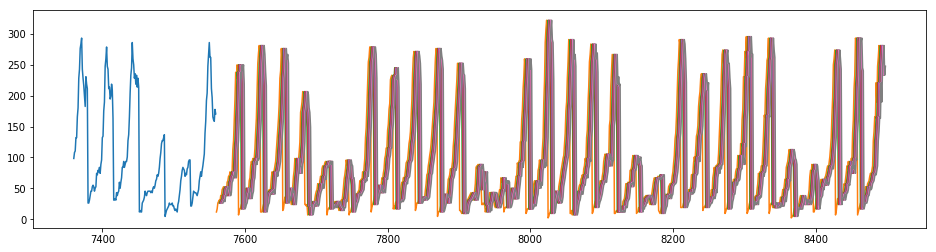

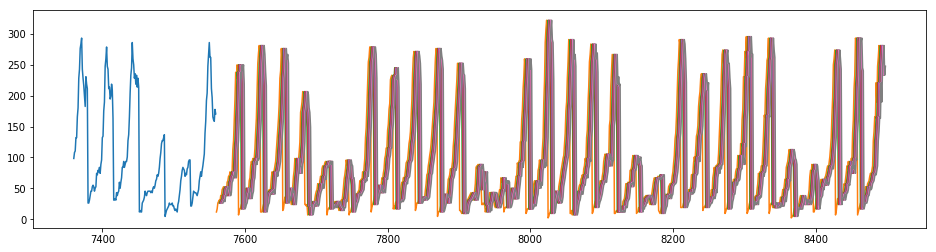

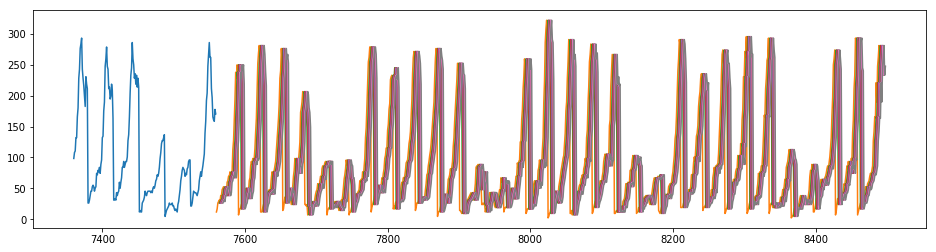

In [39]:
plot_predictions(x, x_val, armax_predictions, horizons=[1, 2, 3, 4, 5, 6], n=200)
plot_predictions(x, x_val, six_predictions, horizons=[1, 2, 3, 4, 5, 6], n=200)
plot_predictions(x, x_val, sarimax_predictions, horizons=[1, 2, 3, 4, 5, 6], n=200)

In [25]:
def plot_fitted_values(x, results, n=500):
    plt.figure(figsize=(16, 4))
    plt.plot(x[-n:])
    plt.plot(results.fittedvalues[-n:])
    plt.show()

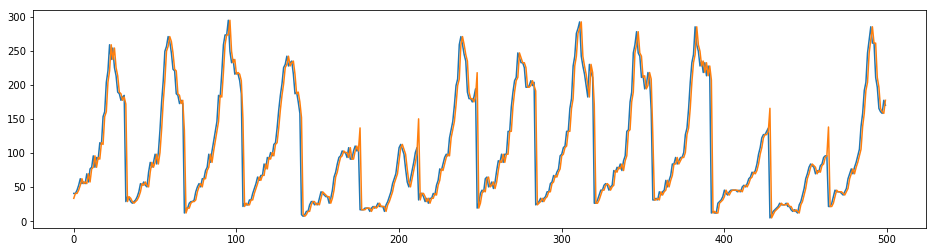

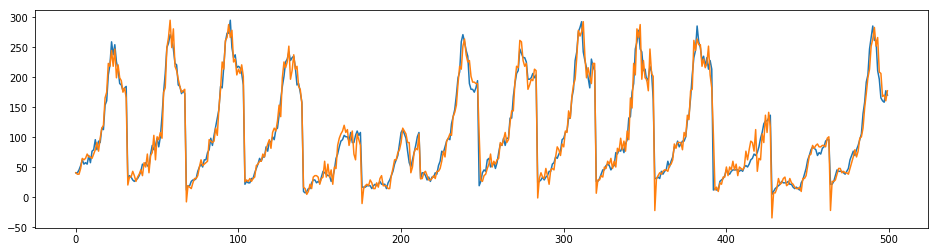

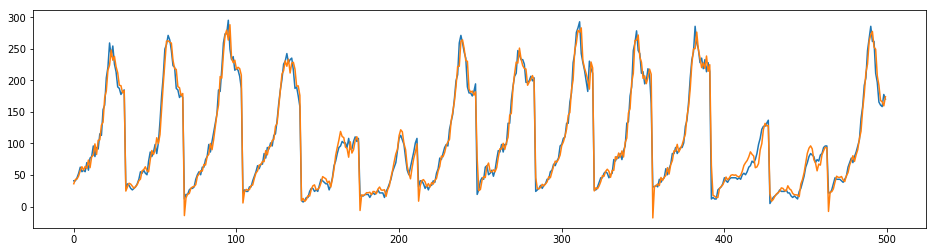

In [26]:
plot_fitted_values(x, armax_results)
plot_fitted_values(x, six_results)
plot_fitted_values(x, sarimax_results)

In [64]:
res_online = []
preds_online = []

for order, seasonal_order in orders:
    results, predictions = fit_online_armax(x, order, seasonal_order, x_val, y_val, x_ts_val, y_ts_val)
    res_online.append(results)
    preds_online.append(predictions)

ValueError: Non-stationary starting autoregressive parameters found with `enforce_stationarity` set to True.